In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mpmath
import math
import time as t

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, lfilter, freqz, filtfilt

In [2]:
def SB(bws, n, t):
    if n == 0 and t == 0:
        return 1
    elif n > 0 and t == 0:
        return 0
    else:
        return np.real(np.sign(bws * t) * np.emath.sqrt((2 * n + 1) / (2 * bws * t)) * mpmath.besselj(n+0.5, bws * np.pi * t)) 

In [3]:
def get_samples_at_timestamps(time_array, signal_array, target_timestamps):
    # Convert to numpy arrays for easier manipulation
    time_array = np.array(time_array)
    signal_array = np.array(signal_array)
    
    # Find the indices where the time matches the target timestamps
    indices = np.where(np.isin(time_array, target_timestamps))[0]
    
    # Return the signal values at those indices
    return signal_array[indices]

def elements_in_one_not_in_another(arr1, arr2):
    # Use numpy's setdiff1d to find elements in arr1 that are not in arr2
    return np.setdiff1d(arr1, arr2)

In [4]:
def RemoveSamples(sig_arr, time_arr, percentage):
    """
    Removes samples from the signal and time arrays based on a given probability.
    
    Parameters:
        sig_arr (np.array): Array of signal values.
        time_arr (np.array): Corresponding time values.
        percentage (float): Probability of removing each sample (0 to 1).
    
    Returns:
        np.array: Filtered signal values.
        np.array: Filtered time values.
    """
    
    mask = np.random.rand(len(sig_arr)) > percentage

    # Apply the mask
    feature_arr = sig_arr[mask]
    time_arr = time_arr[mask]

    return feature_arr, time_arr

In [5]:
def get_samples_at_timestamps(time_array, signal_array, target_timestamps):
   
    time_array = np.array(time_array)
    signal_array = np.array(signal_array)
    
    # Find the indices where the time matches the target timestamps
    indices = np.where(np.isin(time_array, target_timestamps))[0]
    
    # Return the signal values at those indices
    return signal_array[indices]

In [6]:
num_t =500
DEG = 100
legendre_B = np.zeros((DEG+1, num_t))
bws = 0.5

for i in range(num_t):
    for deg in range(DEG+1):
        legendre_B[deg, i] =SB(bws, deg, i-num_t//2)

In [7]:
def reconstruct_signal_using_windows(full_signal,full_time, full_range_array, window_size, recon_size, overlap_size):
    global num_t, DEG
    '''
    This code reconstructs a given signal at range_array time_intervals 
    from a non uniformly sampled signal by combining multiple windows.
    '''
    
    regula = 14.5
    mu = 10 ** -regula  # regularization factor for least squares
    unit_time = 1
    
    app_signal_windows = []
    app_time_windows = []
    
    pos = full_time[0]
    start_index = 0
    start_index_range = 0
    step_size = window_size - overlap_size
    
    total_duration = full_time[-1] - full_time[0]  # Calculate the total time duration of the signal
    step_size = (window_size - overlap_size)  # Calculate step size based on window size and overlap
    number_of_windows = int(total_duration / (step_size * unit_time))  # Find the number of windows
    
    window = 0
    
    total_time =0
    while pos + window_size*unit_time <= full_time[-1]:
        
        window+=1
        
        start_time = t.time()
        
        ##Getting the window to reconstruct
        end_index = start_index
        while full_time[end_index] < pos + window_size*unit_time :
            
            end_index+=1
        if start_index == end_index:
            end_index = len(full_signal)
            
        start_index_range = 0
        while full_range_array[start_index_range] <= pos + (window_size//2-recon_size//2)*unit_time :
            start_index_range +=1
            
        signal= full_signal[start_index:end_index]
        time = full_time[start_index:end_index]
        
        #Centering the time around zero
        sub = time[len(time)//2]
        time = time - sub
        
        #Getting the time window to reconstruct
        new_start_index = start_index
        while full_time[new_start_index] <= pos + step_size*unit_time :
            new_start_index+=1
        start_index = new_start_index-1
    
        lh = len(signal)
        
        #Input matrix
        A = np.zeros((lh, DEG + 1))
        for k in range(DEG + 1):
            for j in range(lh):
                A[j, k] = legendre_B[k, time[j]+int(num_t//2)]

        #LSF
        CDs = np.linalg.solve(np.dot(A.T, A) + mu * np.eye(DEG + 1), np.dot(A.T, signal))
        range_array = []
        
        #Getting the next startpoint for the window
        next_time = start_index_range
    
        while full_range_array[next_time]<= (pos + (window_size//2+recon_size//2 )*unit_time) :
            next_time+=1

        ##Getting the window to reconstruct
        range_array = full_range_array[start_index_range: next_time]
        original_range_array = range_array
        range_array = range_array - sub
        original_range_array = original_range_array[(range_array>time[0]) & (range_array<time[-1])]
        range_array = range_array[(range_array>time[0]) & (range_array<time[-1])] ##To remove points outside the known range
        
        ##Calculating reconstruction matrix
        N = len(range_array)//2
        if (len(range_array)%2):
            B = np.zeros((DEG + 1, 2 * N+1 ))
        else: 
            B = np.zeros((DEG + 1, 2 * N ))
        for k in range(DEG + 1):
            for j in range(-N, N+1):
                if (j==N and len(range_array)%2==0):
                    break
                B[k, N + j] = legendre_B[k, range_array[N+j] +int(num_t//2)]

        app = np.dot(CDs, B) ##Calculating the approximation
        app = app.reshape(-1,1)
        app_signal_windows.append(app.reshape(1, -1))
        app_time_windows.append(original_range_array.reshape(1, -1))
        
        pos = pos + step_size*unit_time
        end_time = t.time()
        total_time+= (end_time-start_time)

    return app_signal_windows, app_time_windows

In [8]:
def concatenate_signals_with_overlap(signals, times):
    """
    Concatenates multiple signal windows with corresponding time points, averaging overlap areas.
    
    Parameters:
    - signals: List of arrays of shape (1, d), each array representing a signal window.
    - times: List of arrays, each array representing the corresponding time points for each signal.
    
    Returns:
    - concatenated_signal: Array of the final concatenated signal with overlap averaging.
    - final_times: Array of the corresponding times for the concatenated signal.
    """
    
    concatenated_signal = np.array([])  # Store the concatenated signal
    final_times = np.array([])          # Store the corresponding time values
    
    for i, signal in enumerate(signals):
        signal = signal.flatten()  # Convert shape (1, d) to (d,)
        current_times = times[i]   # Corresponding time points for the current signal
        current_times = current_times.flatten() 
        count=0
        if i == 0:
            # Initialize with the first signal and its time points
            concatenated_signal = signal
            final_times = current_times
        else:
            # Find overlapping time points with the previous signal
            previous_times = final_times
            common_times = np.intersect1d(previous_times, current_times)
            
            if len(common_times) > 0:
                count+=1
                # Get indices of overlapping times in both previous and current signals
                prev_indices = np.searchsorted(previous_times, common_times)
                curr_indices = np.searchsorted(current_times, common_times)
                
                # Average the overlapping signal values
                concatenated_signal[prev_indices] = (
                    concatenated_signal[prev_indices] + signal[curr_indices]
                ) / 2
                
                # Append non-overlapping parts of the current signal
                non_overlap_indices = np.where(current_times > previous_times[-1])[0]
                if len(non_overlap_indices) > 0:
                    concatenated_signal = np.concatenate([concatenated_signal, signal[non_overlap_indices]])
                    final_times = np.concatenate([final_times, current_times[non_overlap_indices]])
            else:
                # No overlap, concatenate directly
                concatenated_signal = np.concatenate((concatenated_signal, signal))
                final_times = np.concatenate((final_times, current_times))

    return concatenated_signal, final_times

In [9]:
def calculate_metrics(real, approx, method_name):
    rmse = np.sqrt(np.mean((real - approx) ** 2))
    mae = np.mean(np.abs(real - approx))
    ss_total = np.sum((real - np.mean(real)) ** 2)
    ss_residual = np.sum((real - approx) ** 2)
    r_squared = 1 - (ss_residual / ss_total)

    return {
        "RMSE": rmse,
        "MAE": mae,
        "R²": r_squared
    }

# **Reading Data**

In [ ]:
# Load CSV file
df = pd.read_csv("Input Dataset Path Here")

temperature = df["temperature_average"].to_numpy()
temperature_array = temperature[:1000]

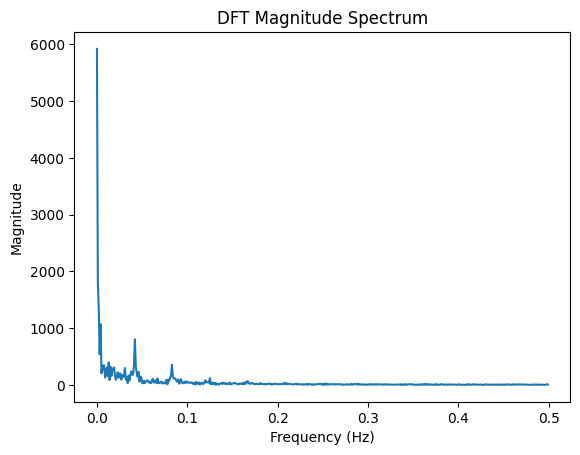

In [11]:
signal = temperature_array
# Compute the DFT using NumPy's FFT
dft = np.fft.fft(signal)

# Compute the frequency axis
freqs = np.fft.fftfreq(len(signal))  # d = sampling interval

# Plot the magnitude spectrum
plt.plot(freqs[:len(freqs)//2], np.abs(dft[:len(dft)//2]))  # Only plot positive frequencies
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("DFT Magnitude Spectrum")
plt.show()

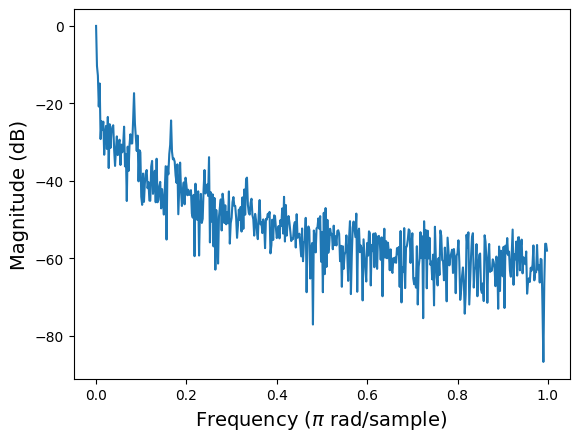

In [ ]:
signal = temperature_array
# Compute the DFT using NumPy's FFT
dft = np.fft.fft(signal)

# Compute the frequency axis
freqs = np.fft.fftfreq(len(signal))  # d = sampling interval

# Plot the magnitude spectrum
plt.plot(2*freqs[:len(freqs)//2], 20*np.log10((np.abs(dft[:len(dft)//2])/np.max(np.abs(dft[:len(dft)//2])))))  # Only plot positive frequencies
plt.xlabel("Frequency ($\\pi$ rad/sample)", fontsize=14)
plt.ylabel("Magnitude (dB)", fontsize=14)

# plt.savefig("dft_magnitude_spectrum_molene.eps", format='eps', dpi=300, bbox_inches='tight')  # Save as EPS
plt.show()

# **Define filter parameters**

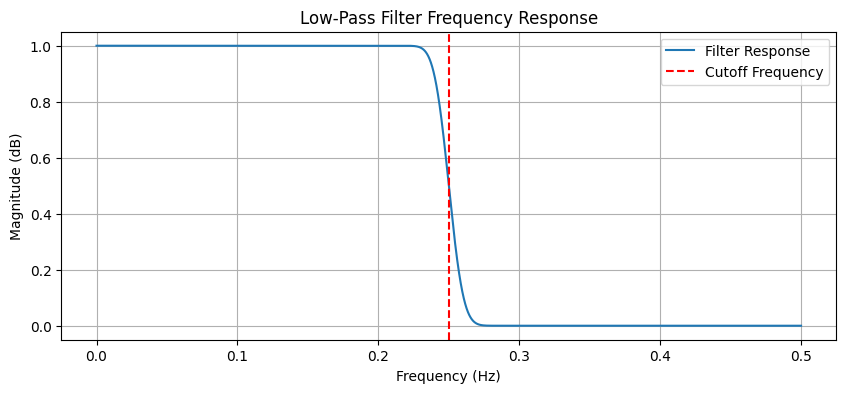

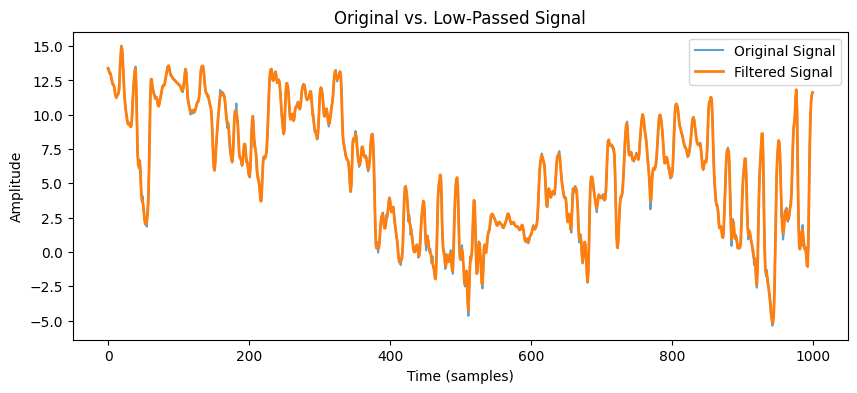

In [13]:
fs = 1  # Sampling frequency (normalized)
cutoff_freq = bws/2 # Cutoff frequency in Hz
num_taps = 301  # Filter order (increase for sharper cutoff)
stopband_atten = 60  # Desired stop-band attenuation in dB

# Design the FIR low-pass filter using the window method
fir_coeffs = firwin(num_taps, cutoff_freq, window=('kaiser', stopband_atten), fs=fs)

# Apply the filter to the signal
filtered_signal = filtfilt(fir_coeffs, 1.0, signal)

# Plot frequency response
w, h = freqz(fir_coeffs, worN=8000, fs=fs)
plt.figure(figsize=(10, 4))
plt.plot(w, (np.abs(h)), label="Filter Response")
plt.axvline(cutoff_freq, color='red', linestyle='--', label="Cutoff Frequency")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title("Low-Pass Filter Frequency Response")
plt.legend()
plt.grid()
plt.show()

# Plot the original and filtered signals
plt.figure(figsize=(10, 4))
plt.plot(signal, label="Original Signal", alpha=0.7)
plt.plot(filtered_signal, label="Filtered Signal", linewidth=2)
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.title("Original vs. Low-Passed Signal")
plt.legend()
plt.show()

# **Removing Samples**

In [15]:
from scipy.interpolate import interp1d
from scipy.interpolate import PchipInterpolator

In [ ]:
num_trials = 100 # Add the number of trials here

In [17]:
temperature_array = filtered_signal
nyint = 1
skip_length = 10/bws
remove_size = 2*nyint/bws
start_time =6 #randomizer

Time = np.arange(len(temperature_array))
remove_percentage = 0.1
temp_arr, time = RemoveSamples(temperature_array, Time, remove_percentage)

window_size = 30/bws
recon_size = 0.25*window_size
overlap_size = 0.8*window_size

rmse_trials = np.zeros((5, num_trials))
mse_trials = np.zeros((5, num_trials))
r_squared_trials = np.zeros((5, num_trials))

missing_percentages = []

for trial in range(num_trials):
    temp_arr, time = RemoveSamples(temperature_array, Time, remove_percentage)

    signal = temp_arr 

    range_array = Time[:]
    app_signal_windows, app_time_windows = reconstruct_signal_using_windows(signal,time,  range_array, window_size, recon_size, overlap_size)
    app_signal, app_time = concatenate_signals_with_overlap(app_signal_windows, app_time_windows)##Combining all the windows

    missing_time_stamps  = elements_in_one_not_in_another(Time, time)

    missing_time_stamps = missing_time_stamps[(missing_time_stamps>=app_time[0]) & (missing_time_stamps<=app_time[-1])]

    real_arr = get_samples_at_timestamps(Time,temperature_array, missing_time_stamps)

    app_arr =  get_samples_at_timestamps(app_time, app_signal, missing_time_stamps)

    errors = calculate_metrics(real_arr, app_arr, "CDs")
    
    rmse_trials[0][trial]= errors["RMSE"]
    mse_trials[0][trial] = errors["MAE"]
    r_squared_trials[0][trial] = errors["R²"]
    
    # Perform linear interpolation
    x_non_uniform = time
    y_non_uniform = signal
    linear_interpolator = interp1d(x_non_uniform, y_non_uniform, kind='linear', fill_value="extrapolate")

    # Get the interpolated values for the uniform grid
    y_linear = linear_interpolator(app_time)
    app_arr = get_samples_at_timestamps(app_time, y_linear, missing_time_stamps)

    linear_errors = calculate_metrics(real_arr, app_arr, "Linear")
    
    rmse_trials[1][trial]= linear_errors["RMSE"]
    mse_trials[1][trial] = linear_errors["MAE"]
    r_squared_trials[1][trial] = linear_errors["R²"]
    
    # Perform spline interpolation
    spline_interpolator = interp1d(x_non_uniform, y_non_uniform, kind='cubic', fill_value="extrapolate")
    y_spline = spline_interpolator(app_time)

    # Perform nearest-neighbor interpolation
    nn_interpolator = interp1d(x_non_uniform, y_non_uniform, kind='nearest', fill_value=np.nan, bounds_error=False)
    y_nn = nn_interpolator(app_time)

    # Get the interpolated values for the uniform grid and apply to missing timestamps
    app_arr_spline = get_samples_at_timestamps(app_time, y_spline, missing_time_stamps)
    app_arr_nn = get_samples_at_timestamps(app_time, y_nn, missing_time_stamps)

    # Calculate and print RMSE for spline interpolation
    spline_errors = calculate_metrics(real_arr, app_arr_spline, "Spline")

    nn_errors = calculate_metrics(real_arr, app_arr_nn, "NN")
    
    rmse_trials[2][trial]= spline_errors["RMSE"]
    mse_trials[2][trial] = spline_errors["MAE"]
    r_squared_trials[2][trial] = spline_errors["R²"]
    
    rmse_trials[3][trial]= nn_errors["RMSE"]
    mse_trials[3][trial] = nn_errors["MAE"]
    r_squared_trials[3][trial] = nn_errors["R²"]
    
    # Perform hermite spline interpolation
    hermite_interpolator = PchipInterpolator(x_non_uniform, y_non_uniform)
    y_hermite = hermite_interpolator(app_time)
    app_arr_hermite = get_samples_at_timestamps(app_time, y_hermite, missing_time_stamps)
    # Calculate and print RMSE for hermite interpolation
    hermite_errors = calculate_metrics(real_arr, app_arr_hermite, "Hermite")
    
    rmse_trials[4][trial]= hermite_errors["RMSE"]
    mse_trials[4][trial] = hermite_errors["MAE"]
    r_squared_trials[4][trial] = hermite_errors["R²"]
    
    missing_percentage = (len(real_arr) / len(range_array)) * 100
    missing_percentages.append(missing_percentage)
    print(f"Trial {trial + 1}/{num_trials} completed.")

Trial 1/10 completed.
Trial 2/10 completed.
Trial 3/10 completed.
Trial 4/10 completed.
Trial 5/10 completed.
Trial 6/10 completed.
Trial 7/10 completed.
Trial 8/10 completed.
Trial 9/10 completed.
Trial 10/10 completed.


# **Getting Results**

In [18]:
print("Statistics for missing percentage of", remove_percentage)
print("====RMSE statistics====")
print("CDs", np.mean(rmse_trials[0]), np.std(rmse_trials[0]), np.std(rmse_trials[0])/np.sqrt(num_trials))
print("Linear", np.mean(rmse_trials[1]), np.std(rmse_trials[1]), np.std(rmse_trials[1])/np.sqrt(num_trials))
print("Spline", np.mean(rmse_trials[2]), np.std(rmse_trials[2]), np.std(rmse_trials[2])/np.sqrt(num_trials))
print("NN", np.mean(rmse_trials[3]), np.std(rmse_trials[3]), np.std(rmse_trials[3])/np.sqrt(num_trials))
print("Hermite", np.mean(rmse_trials[4]), np.std(rmse_trials[4]), np.std(rmse_trials[4])/np.sqrt(num_trials))
print("====MAE statistics=====") 
print("CDs", np.mean(mse_trials[0]), np.std(mse_trials[0]), np.std(mse_trials[0])/np.sqrt(num_trials))
print("Linear", np.mean(mse_trials[1]), np.std(mse_trials[1]), np.std(mse_trials[1])/np.sqrt(num_trials))
print("Spline", np.mean(mse_trials[2]), np.std(mse_trials[2]), np.std(mse_trials[2])/np.sqrt(num_trials))
print("NN", np.mean(mse_trials[3]), np.std(mse_trials[3]), np.std(mse_trials[3])/np.sqrt(num_trials))
print("Hermite", np.mean(mse_trials[4]), np.std(mse_trials[4]), np.std(mse_trials[4])/np.sqrt(num_trials))
print("====missing percentage statistics=====")
print("Mean missing percentage", np.mean(missing_percentages))

Statistics for missing percentage of 0.1
====RMSE statistics====
CDs 1.0623751279912634e-07 3.222550035766399e-08 1.0190597986878895e-08
Linear 0.3082747410877046 0.06131379037614763 0.01938912295667386
Spline 0.07995349006630337 0.0188179528638941 0.0059507591951593886
NN 0.7745032687197855 0.07202498138429102 0.022776298960558685
Hermite 0.18832523597503312 0.04670586738292513 0.01476969210238111
====MAE statistics=====
CDs 7.258604588929892e-08 1.0576774043335243e-08 3.344669627388782e-09
Linear 0.20882649583355678 0.031890303623350345 0.01008459947241075
Spline 0.05231451969367508 0.009117620948557108 0.002883244903950537
NN 0.5387040340619982 0.04851556244334806 0.015341967928510359
Hermite 0.12216324498152024 0.02375830629798797 0.007513036124956507
====missing percentage statistics=====
Mean missing percentage 9.42


In [21]:
from datetime import datetime
from pathlib import Path

In [20]:
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

row = {
    "Timestamp": timestamp,
    "Remove Percentage": remove_percentage,
    "Mean Missing Percentage": np.mean(missing_percentages),

    # RMSE
    "RMSE_CDs_mean": np.mean(rmse_trials[0]),
    "RMSE_CDs_std": np.std(rmse_trials[0]),
    "RMSE_CDs_se": np.std(rmse_trials[0]) / np.sqrt(num_trials),

    "RMSE_Linear_mean": np.mean(rmse_trials[1]),
    "RMSE_Linear_std": np.std(rmse_trials[1]),
    "RMSE_Linear_se": np.std(rmse_trials[1]) / np.sqrt(num_trials),

    "RMSE_Spline_mean": np.mean(rmse_trials[2]),
    "RMSE_Spline_std": np.std(rmse_trials[2]),
    "RMSE_Spline_se": np.std(rmse_trials[2]) / np.sqrt(num_trials),

    "RMSE_NN_mean": np.mean(rmse_trials[3]),
    "RMSE_NN_std": np.std(rmse_trials[3]),
    "RMSE_NN_se": np.std(rmse_trials[3]) / np.sqrt(num_trials),

    "RMSE_Hermite_mean": np.mean(rmse_trials[4]),
    "RMSE_Hermite_std": np.std(rmse_trials[4]),
    "RMSE_Hermite_se": np.std(rmse_trials[4]) / np.sqrt(num_trials),

    # MAE
    "MAE_CDs_mean": np.mean(mse_trials[0]),
    "MAE_CDs_std": np.std(mse_trials[0]),
    "MAE_CDs_se": np.std(mse_trials[0]) / np.sqrt(num_trials),

    "MAE_Linear_mean": np.mean(mse_trials[1]),
    "MAE_Linear_std": np.std(mse_trials[1]),
    "MAE_Linear_se": np.std(mse_trials[1]) / np.sqrt(num_trials),

    "MAE_Spline_mean": np.mean(mse_trials[2]),
    "MAE_Spline_std": np.std(mse_trials[2]),
    "MAE_Spline_se": np.std(mse_trials[2]) / np.sqrt(num_trials),

    "MAE_NN_mean": np.mean(mse_trials[3]),
    "MAE_NN_std": np.std(mse_trials[3]),
    "MAE_NN_se": np.std(mse_trials[3]) / np.sqrt(num_trials),

    "MAE_Hermite_mean": np.mean(mse_trials[4]),
    "MAE_Hermite_std": np.std(mse_trials[4]),
    "MAE_Hermite_se": np.std(mse_trials[4]) / np.sqrt(num_trials),
}


In [ ]:
csv_path = Path("Insert CSV File Path Here to Save Results")

df = pd.DataFrame([row])

df.to_csv(
    csv_path,
    mode="a",
    header=not csv_path.exists(),  # write header only once
    index=False
)